# Set up environment
Let's load the basic modules and read the tables from disk

In [ ]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

We will now load the two tables we generated in the last session. `data1` contains the Gaia query in a rectangle around our region of interest, excluding negative parallaxes. `cluster1` is our selection on the previous table to select sources with parallaxes between 5.0 and 5.7 mas.

⚠️ If you want to use the "official" `data1` and `cluster1` tables instead of the ones created by yourself do:
- open a terminal
- Navigate to the data folder  
`cd pysnacks_1/tutorials/data`
- Delete the files `data1.ecsv` and `cluster1.ecsv`.

In [ ]:
import os
for my_file in ['data1', 'cluster1']:
    if not os.path.isfile(f'../data/{my_file}.ecsv'):
        print(f'Using official {my_file} file')
        os.system(f'unzip ../data/backup/{my_file}.ecsv.zip')
        os.system(f'mv {my_file}.ecsv ../data')
    else:
        print(f'Doing nothing because ../data/{my_file}.ecsv already exists')

In [ ]:
data1 = Table.read('../data/data1.ecsv')
cluster1 = Table.read('../data/cluster1.ecsv')

# ADQL searches

Astronomical Data Query Language (ADQL) is a language based on the Structured Query Language (SQL) but developed for astronomy to query catalogs and tables following Virtual Observatory standards. Full specifications can be found [here](https://www.ivoa.net/documents/ADQL/20180112/PR-ADQL-2.1-20180112.html).

- This [ADQL Cheat Sheet](http://simbad.u-strasbg.fr/simbad/tap/help/adqlHelp.html) is very useful.
- Many ready-to-use ADQL examples on Gaia data: https://gaia.ari.uni-heidelberg.de/tap.html

In [ ]:
from astroquery.gaia import Gaia

Gaia provides a large amount of tables. If you want to see all available tables (including many cross-matches with other catalogs like SDSS, WISE, UCAC4, Hipparcos, etc) you can run `Gaia.load_tables(only_names=True)`.

In [ ]:
tables = Gaia.load_tables(only_names=True)
for table in tables:
    print(table.name)

For this tutorial we are going to use table the full Gaia EDR3 catalog:  
`gaiaedr3.gaia_source`

## Basic ADQL query

There are 3 main stages for a query:
1. Write the query as a text string
2. Launch the job with the function `Gaia.launch_job()`
3. Convert the job into an astropy Table with `job.get_results()`.

The query will be written as a python string, which we will send to the Gaia server as a job. The main ingredients to write a query are these statements:
- `SELECT`: this statement is used to select data from a database.
- `TOP`: to limit the query to a certain number of rows. Be careful not to download too many rows!
- `FROM`: to indicate the table we want to query.
- `WHERE`: to include a filter to select specific data. `AND` to include additional filters.

Although it is not a formal requirement, these statements are usually included in CAPITAL letters, while our values are written in lowercase.

In [ ]:
query1 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
"""

Note that dividing in lines and adding spaces is just to make it nice. 4-space identation is not relevant. The query could be written as:
```python
query1 = "SELECT TOP 10 ra, dec, pmra, pmdec, parallax FROM gaiaedr3.gaia_source"
```

In [ ]:
job1 = Gaia.launch_job(query1)   # Here is where the data are downloaded!

In [ ]:
table1 = job1.get_results()

In [ ]:
table1

Now let's add a filter. This will be filtered in the input catalog and we only retrieve the resulting filtered table, which makes it fast:

In [ ]:
query2 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 250
"""
job2 = Gaia.launch_job(query2)
table2 = job2.get_results()
table2

And adding additional filters is also easy:


In [ ]:
query3 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 10
    AND dec BETWEEN 55 AND 60
    AND pmra > 100
"""
job3 = Gaia.launch_job(query3)
table3 = job3.get_results()
table3

How do we know which columns are available, their units and the description? We can get the table metadata with `Gaia.load_table()`:

In [ ]:
table_metadata = Gaia.load_table('gaiaedr3.gaia_source')
for column in table_metadata.columns:
    print(f"{column.name:31}: {column.unit:16} :  {column.description}")

### ⛏ Exercise 3.1
Construct and run a query named `job3_1` using the following information:
- Select 10 rows.
- Query table `gaiaedr3.gaia_source`.
- Select columns: right ascension, declination and phot_g_mean_mag.
- Use filters to select stars with declination between 50 and 80 deg and magnitude brighter than 10.

In [ ]:
query3_1 = """
SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10
"""
job3_1 = Gaia.launch_job(query3_1)
table3_1 = job3_1.get_results()
table3_1

We can rename columns and give a name to the table.

In [ ]:
query4 = """
SELECT
TOP 10
    ra AS right_ascension, dec AS declination, pmra, pmdec, parallax AS plx, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job4 = Gaia.launch_job(query4)
table4 = job4.get_results()
table4

We can create new columns as combinations of other ones including complex operations.


In [ ]:
query5 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, pmra_error, pmdec_error,
    sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) AS pm_error
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
    AND sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) < 0.1
"""
job5 = Gaia.launch_job(query5)
table5 = job5.get_results()
table5

Computing the distance in kpc is as easy as creating a new column using 1/parallax[mas]. Note: you cannot call the column "distance" because that is a reserved ADQL statement.

In [ ]:
query6 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 1
    AND dec > 60
    AND pmra > 100
"""
job6 = Gaia.launch_job(query6)
table6 = job6.get_results()
table6['distance_kpc'].unit = u.kpc   # It is always good to define the units of new columns as soon as they are created.
table6

For example, as we did in previous session, we can directly compute the absolute magnitude and create a new column:

In [ ]:
query7 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag,
    gaia.phot_g_mean_mag + 5*log10(gaia.parallax) - 10 AS g_mag_abs
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job7 = Gaia.launch_job(query7)
table7 = job7.get_results()
table7

## Select by region

In [ ]:
query8 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec), CIRCLE(15, 60, 0.1)) = 1
"""
job8 = Gaia.launch_job(query8)
table8 = job8.get_results()
table8

## Create a query programatically

This is useful when we want to separate the query template from the actual variables we want to use, for example by defining the columns or the table name as independent variables.

In [ ]:
my_columns = 'ra, dec, phot_g_mean_mag'
my_table = 'gaiaedr3.gaia_source'
min_dec = 50
max_dec = 80
max_mag = 10

In [ ]:
query9 = f"""
SELECT
TOP 10
    {my_columns}
FROM
    {my_table}
WHERE
    dec BETWEEN {min_dec} AND {max_dec}
    AND phot_g_mean_mag < {max_mag}
"""
print(query9)

In [ ]:
job9 = Gaia.launch_job(query9)
table9 = job9.get_results()
table9

You can verify that `query9` is exactly the same as `query3_1` and the `table9` is the same as `table3_1`.

In [ ]:
print(query9, query3_1)

In [ ]:
print(table9)
print(table3_1)

### ⛏ Exercise 3.2
Find all the stars around Vega in a radius of 50 arcsec. (Don't use `TOP`).
- Use `SkyCoord.from_name()` to get the coordinates of the star Vega and store them in `vega_coord`. You can get the R.A and Dec in degress with `vega_coord.ra.deg` and `vega_coord.dec.deg`, respectively.
- Run an ADQL query to find stars within 50 arcsec of that position to obtain columns 'ra, dec, phot_g_mean_mag, distance_kpc'. Create a new column `distance_kpc` by transforming the parallax.
- Is Vega included in the resulting table? Read more [I can not find data for a bright star. Why is that?](https://www.cosmos.esa.int/web/gaia/faqs#BrightStar). Also, read about the VEGAMAG system [here](https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html#SSS6):
> The VEGAMAG system is defined so that Vega’s colours are all zero: this is equivalent to normalizing all the observed fluxes to the flux of Vega.

In [ ]:
vega_coord = SkyCoord.from_name("Vega")
search_radius = 50/60/60 # We need in degrees

print(vega_coord)

In [ ]:
query3_2 = f"""
SELECT
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
print(query3_2)

In [ ]:
job3_2 = Gaia.launch_job(query3_2)
table3_2 = job3_2.get_results()
table3_2

### 🌪 Additional fun
Repeat the query around Vega but with a radius of 100 arcsec. Select 50 rows. Make a plot of the R.A. and Dec. of the resulting stars.

In [ ]:
vega_coord = SkyCoord.from_name("Vega")
vega_coord.to_string('hmsdms')
search_radius = 100/60/60 # We need in degrees
query3_2b = f"""
SELECT
TOP 50
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
job3_2b = Gaia.launch_job(query3_2b)
table3_2b = job3_2b.get_results()
table3_2b

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(table3_2b['ra'], table3_2b['dec'], 'o')
ax.plot(vega_coord.ra.deg, vega_coord.dec.deg, '+', color='r', ms=50)

ax.set_aspect('equal')

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Declination [deg]');

## Query the region of interest around our star cluster
Now we will repeat the search we did in sessions 1 and 2: all Gaia stars in a rectangle of 3 deg x 2 deg centred at R.A. 130.025 deg and Dec. 19.98333 deg. Then, we created `data1` selecting only positive parallaxes and we added the distance and absolute magnetiude columns. We will do all steps in a single go with ADQL.

In [ ]:
my_table = 'gaiaedr3.gaia_source'
min_ra = 130.025 - 3/2
max_ra = 130.025 + 3/2
min_dec = 19.98333 - 2/2
max_dec = 19.98333 + 2/2
min_parallax = 0

In [ ]:
# We defined gaia_columns as a python list in tutorial 1. Here we need a single string
gaia_columns = ['ra','dec','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_matched_transits','phot_g_mean_flux','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp','dr2_radial_velocity','dr2_radial_velocity_error','dr2_rv_template_teff']
my_columns = ', '.join(gaia_columns)  # This creates a comma-separated string from a list
my_columns

Apart from `my_columns` we will create two new columns: `distance_kpc` and `g_mag_abs`.

In [ ]:
query_final = f"""
SELECT
TOP 35000
    {my_columns},
    1/parallax AS distance_kpc,
    phot_g_mean_mag + 5*log10(parallax) - 10 AS g_mag_abs
FROM
    {my_table}
WHERE
    ra BETWEEN {min_ra} AND {max_ra}
    AND dec BETWEEN {min_dec} AND {max_dec}
    AND parallax > {min_parallax}
"""
print(query_final)

In [ ]:
job_final = Gaia.launch_job(query_final)
data1_adql = job_final.get_results()

In [ ]:
data1_adql

Are the table obtained with ADQL exactly the same as the one obtained with astroquery and modified as a table? Let's see if the number of entries and some average values match exacty.

In [ ]:
print(len(data1),               len(data1_adql))                   # The number of entries
print(data1['ra'].mean(),       data1_adql['ra'].mean())           # Same mean R.A.?
print(data1['parallax'].mean(), data1_adql['parallax'].mean())     # Same mean parallax?
print(data1['distance'].mean(), data1_adql['distance_kpc'].mean()) # Same mean computed distance?
print(data1['Mg'].mean(),       data1_adql['g_mag_abs'].mean())    # Same mean computed absolute magnitude?
print('Yes!')

# Advanced plotting with multiple panels

For this section we have two main objectives:
- Describe how to manage plots with multiple panels.
- Write functions to simplify the plot management.

## Multiple subplots in a single figure

You can use  
`fig, ax = plt.subplots(ncols=XX, nrows=YY, figsize=(14,6))`  
to create XX times YY panels in a single plot. Now `ax` will be an array of size (XX, YY).

Here are some example of how `ax` looks like when creating multiple panels:

- When you use ncols=2, nrows=1:
  - `ax[0]` left panel
  - `ax[1]` right panel

- When you use ncols=1, nrows=2:
  - `ax[0]` top panel
  - `ax[1]` bottom panel
  
- When you use ncols=2, nrows=3:
  - `ax[0, 0]` top    left  panel
  - `ax[1, 0]` middle left  panel
  - `ax[2, 0]` bottom left  panel
  - `ax[0, 1]` top    right panel
  - `ax[1, 1]` middle right panel
  - `ax[2, 1]` bottom right panel

In summary, the general nomenclature is [row, column]

In [ ]:
col1 = 'parallax'
col2 = 'distance'

fig, ax = plt.subplots(ncols=2, figsize=(14,6))# We can select ncols, nrows, or both.

ax[0].hist(data1[col1], bins=np.arange(0, 8, 0.05), label=data1[col1].description)   # histogram of column 1
ax[1].hist(data1[col2], bins=np.arange(0, 4, 0.02), label=data1[col2].description)   # histogram of column 2

ax[0].legend()                                 # Activate the panel legend, which will show the "label" we specified
ax[1].legend()                                 # Activate the panel legend, which will show the "label" we specified

description1 = data1[col1].description         # Obtain column 1 description
unit1 = data1[col1].unit                       # Obtain column 1 units
description2 = data1[col2].description         # Obtain column 2 description
unit2 = data1[col2].unit                       # Obtain column 2 units

ax[0].set_xlabel(f"{description1} [{unit1}]")  # Set the axis label in the form "Variable description [units]"
ax[1].set_xlabel(f"{description2} [{unit2}]")  # Set the axis label in the form "Variable description [units]"

ax[0].set_ylabel('Number of stars')
ax[1].set_ylabel('Number of stars');

### ✨ Exercise 3.3

- Prepare a 2x2 figure with histograms for `ra`, `dec`, `parallax`, `distance`. Use `plt.subplots(ncols=2, nrows=2` and select a figsize in accordance to the number of plots.
- You can access each axis (panel) with `ax[0,0]`, `ax[0,1]`, `ax[1,1]`, `ax[1,0]`, clockwise.
- For labels (which will be shown with legend()) use the column description.
- Remember to add labels and a legend for all axes.
- Remember to include `xlabel` (automatically) and `ylabel` (manually) for all axes.

In summary, obtain a figure similar to:

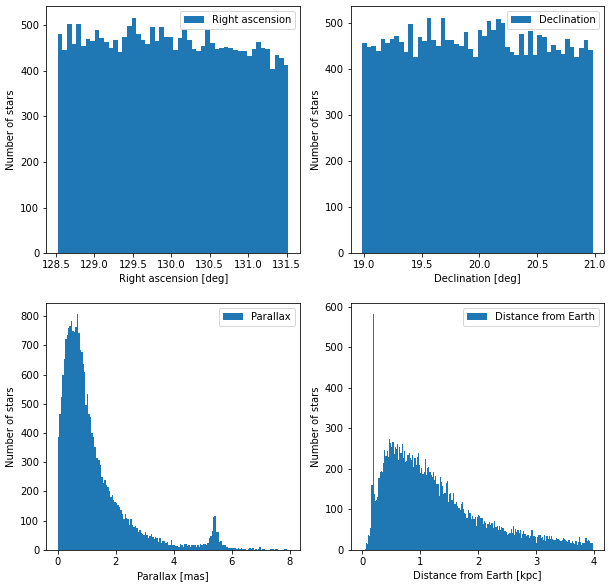

In [ ]:
col1 = 'ra'
col2 = 'dec'
col3 = 'parallax'
col4 = 'distance'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))   # We can select ncols, nrows, or both.

ax[0,0].hist(data1[col1], bins=50, label=data1[col1].description)
ax[0,1].hist(data1[col2], bins=50, label=data1[col2].description)
ax[1,0].hist(data1[col3], bins=np.arange(0, 8, 0.05), label=data1[col3].description)
ax[1,1].hist(data1[col4], bins=np.arange(0, 4, 0.02), label=data1[col4].description)


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

description1 = data1[col1].description
unit1 = data1[col1].unit
description2 = data1[col2].description
unit2 = data1[col2].unit
description3 = data1[col3].description
unit3 = data1[col3].unit
description4 = data1[col4].description
unit4 = data1[col4].unit

ax[0,0].set_xlabel(f"{description1} [{unit1}]")
ax[0,1].set_xlabel(f"{description2} [{unit2}]")
ax[1,0].set_xlabel(f"{description3} [{unit3}]")
ax[1,1].set_xlabel(f"{description4} [{unit4}]")

ax[0,0].set_ylabel('Number of stars')
ax[0,1].set_ylabel('Number of stars')
ax[1,0].set_ylabel('Number of stars')
ax[1,1].set_ylabel('Number of stars');

### 🌪 Exercise
Redo the previous plot show each panel shows both the Total Sample and the Cluster subset.

## Simplify repetitive tasks with loops over axes/columns

First, let's see a basic example with the use of `zip`, which iterates over multiple lists at the same time.

In [ ]:
x = [1,   2,  3]
y = [10, 20, 30]

for xi, yi in zip(x, y):
    print(xi,yi)

In [ ]:
col1 = 'pmdec'
col2 = 'dec'
cols = [col1, col2]   # We define a list of columns to plot

fig, ax = plt.subplots(ncols=2, figsize=(10,5))   # We can select ncols, nrows, or both.

for axi, col in zip(ax, cols):        # zip allows you to iterate over multiple variables
    axi.hist(data1[col], bins=80)

In [ ]:
col1 = 'parallax'
col2 = 'distance'
cols = [col1, col2]   # We define a list of columns to plot

fig, ax = plt.subplots(ncols=2, figsize=(14,6))   # This plot will have two panels in a single horizontal row.

for axi, col in zip(ax, cols):
    axi.hist(data1[col],    bins=np.arange(0, 7, 0.05), label='Full sample')  # This plots the blue histogram
    axi.hist(cluster1[col], bins=np.arange(0, 7, 0.05), label='Cluster')      # This plots the orange histogram
    axi.legend()
    
    description = data1[col].description
    unit = data1[col].unit

    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')

## Function to make simple plots. The `**kwargs` trick

We can simplify the process even more the process by writting a function that does the repetitive syntax by itself. To be able to use different properties for each panel (for example symbol colors, sizes, labels, etc) we will use `**kwargs`, which basically translates into "any other variable included when calling the function will be passed along".

This function will create a single `scatter` plot of two variables.

In [ ]:
def plot_variables(data, col1, col2, ax, **kwargs):
    
    ax.scatter(data[col1], data[col2], **kwargs)

    description1 = data1[col1].description        # Obtain column 1 description
    unit1 = data1[col1].unit                      # Obtain column 1 units
    description2 = data1[col2].description        # Obtain column 2 description
    unit2 = data1[col2].unit                      # Obtain column 2 units

    ax.set_xlabel(f"{description1} [{unit1}]") # Set the axis label in the form "Variable description [units]"
    ax.set_ylabel(f"{description2} [{unit2}]") # Set the axis label in the form "Variable description [units]"

    ax.legend()
    return

In [ ]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=1, c='k',      label='Full sample', alpha=0.2)
plot_variables(cluster1, col1, col2, ax, s=2, c='tomato', label='Cluster')

ax.loglog();

Now will create a figure with two panels, the left one for `parallax_error` vs `phot_g_mean_flux` and the right one for `pmra_error` vs `pmra`.

In [ ]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'
col3 = 'pmra'
col4 = 'pmra_error'

fig, ax = plt.subplots(ncols=2, figsize=(14,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax[0], s=1, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax[0], s=2, c='tomato', label='Cluster')

plot_variables(data1,    col3, col4, ax[1], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col3, col4, ax[1], s=3, c='tomato', label='Cluster')

# Other options specific to the panel need to be specified individually
ax[0].loglog()
ax[1].set_xlim(-60, 60);

## Velocity distribution analysis
We will try to find some clustering pattern in the velocity space. These are the variables:  

Proper motion in right ascension is $\mu_{\alpha}\cos\delta$  
Proper motion in declination is $\mu_{\delta}$  
Spectroscopic radial velocity in the solar barycentric reference frame is $v_{r}$

### ✨ Exercise 3.4

- Make a plot with a single panel to show the proper motion in declination vs the proper motion in right ascension for the full sample and for the cluster. The full sample table is `data1` and the cluster table is`cluster1`. Use the function `plot_variables()`.
- Use different colors for the full sameple and the cluster.
- Use `ax.set_aspect('equal')` so both axes represent the same scales.
- Repeat the plot to zoom with until you see the relevant part of the plot by setting `ax.set_xlim` and `ax.set_ylim` 
- Can you approximately guess the mean proper motion of the cluster?

In [ ]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=3, c='tomato', label='Cluster');

In [ ]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.set_aspect('equal')
ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30);

Great, this is much clearer! The cluster is a moving group, where most of the stars have a very similar 2D velocity, even if they are positionally scattered in a wide region of the sky of several degrees. This indicates that the cluster of stars, probably very young, was formed at a similar time from a single gas cloud, so on average they have the same space velocity as the original cloud.

Note that the selection based on distance alone gives a large contamination of stars that don't look like stars from the cluster. A better selection algorithm is needed to avoid those outliers.

### 🌪 Exercise

Repeat the previous plot and include a cross on the average proper motion of the cluster, and the median proper motion of the cluster. Use values from the `cluster1` table to plot the crosses.

In [ ]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.scatter(cluster1['pmra'].mean(), cluster1['pmdec'].mean(),
           marker='+', c='b', s = 400, label='mean cluster')
ax.scatter(np.median(cluster1['pmra']), np.median(cluster1['pmdec']),
           marker='+', c='g', s = 400, label='median cluster')

ax.set_aspect('equal')

ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30)

ax.legend();

### 🌪 Exercise

Make a three-panel plot to represent all the stars in `data1` and show:
- `pmdec` vs `pmra`
- `dr2_radial_velocity` vs `pmra`
- `dr2_radial_velocity` vs `pmdec`

- Draw horizontal and vertical lines at the center of the cluster using `axvline()` and `axhline()`.

In [ ]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'dr2_radial_velocity'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax[0,0], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col1, col3, ax[1,0], s=5, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col3, col2, ax[0,1], s=5, c='k', alpha=0.2, label='Full sample')

ax[0,0].set_aspect('equal')
ax[0,0].set_xlim(-50, 20)
ax[0,0].set_ylim(-40, 30)
ax[1,0].set_xlim(-50, 20)
ax[0,1].set_ylim(-40, 30)

ax[0,0].axvline(np.median(cluster1[col1]), color='k', lw=0.5)
ax[0,0].axhline(np.median(cluster1[col2]), color='k', lw=0.5)
ax[1,0].axvline(np.median(cluster1[col1]), color='k', lw=0.5)
ax[0,1].axhline(np.median(cluster1[col2]), color='k', lw=0.5);

### 🌪 Exercise

- Use a `for` loop to make a 3 panel plot showing the histograms for `pmra`, `pmdec` and `radial_velocity`
- Include both the full sample and the cluster subset.
- Make sure each panel has an adequate `bins` distribution, and that it is the same for the full and cluster samples. Tip: you can create a list with 3 items, each one being a `np.linespace` object.
- Tip2: for `radial_velocity` select the `bins` that do not select value 0, for example use `np.linspace(1, 60, 50)`.

In [ ]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'dr2_radial_velocity'

cols = [col1, col2, col3]
fig, ax = plt.subplots(ncols=3, figsize=(16,6))   # We can select ncols, nrows, or both.

bins = [
    np.linspace(-40, 40, 100),
    np.linspace(-40, 40, 100),
    np.linspace(1, 60, 50)
]

for col, axi, binsi in zip(cols, ax, bins):
    axi.hist(data1[col], bins=binsi, label='Full sample')
    axi.hist(cluster1[col], bins=binsi, label='Cluster')
    axi.legend()
            
    description = data1[col].description
    unit = data1[col].unit

    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')

## Velocity field
Finally, we can plot the velocity field of the stars. Given the large number of stars it is difficult to have a clear picture of the velocity directions and magnitudes of the whole sample. But at least we can see that the great majority of the sample stars have random velocities on all directions while the cluster stars have a predominant 2D direction and sense.

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(12,8))

ax.quiver(data1['ra'], data1['dec'], data1['pmra'], data1['pmdec'],
          alpha=0.2, scale=1200, label='Full sample');

ax.quiver(cluster1['ra'], cluster1['dec'], cluster1['pmra'], cluster1['pmdec'],
           alpha=1, color='tomato', scale=1200, label='Cluster');
ax.set_aspect('equal')

ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

# Analysis of the cluster kinematics in the Galaxy


`SkyCoord` function is much more powerful than just storing positions. In particular we can include also velocities (both in the plane of the sky and radial), or also cartesian coordinates. Let's start by simply adding the proper motions. 

In [ ]:
# For the full sample
data1_coord = SkyCoord(ra  = data1['ra'],
                       dec = data1['dec'],
                       pm_ra_cosdec = data1['pmra'],
                       pm_dec = data1['pmdec'],
                       frame = 'icrs')

data1_galactic = data1_coord.galactic

# For the selected cluster
cluster1_coord = SkyCoord(ra  = cluster1['ra'],
                          dec = cluster1['dec'],
                          pm_ra_cosdec = cluster1['pmra'],
                          pm_dec = cluster1['pmdec'],
                          frame = 'icrs')
cluster1_galactic = cluster1_coord.galactic

In [ ]:
cluster1_galactic[0:5]

Now we are going to repeat the three basic plots (position, velocities and quiver plot) but using galactic coordinates.

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.l,
        data1_galactic.b,
        color='grey', marker='.', ms=0.5, ls='')

ax.plot(cluster1_galactic.l,
        cluster1_galactic.b,
        color='tomato', marker='.', ls='')

ax.set_aspect('equal')

ax.set_xlabel('l [deg]')
ax.set_ylabel('b [deg]');

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.pm_l_cosb,
        data1_galactic.pm_b,
        color='grey', marker='.', ms=0.5, ls='')

ax.plot(cluster1_galactic.pm_l_cosb,
        cluster1_galactic.pm_b,
        color='tomato', marker='.', ls='')

ax.set_xlim(-50, 60)
ax.set_ylim(-60, 50)
ax.set_aspect('equal')

ax.set_xlabel('pm l [mas/yr]')
ax.set_ylabel('pm b [mas/yr]');

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,10))

ax.quiver(data1_galactic.l.value, data1_galactic.b.value,
          data1_galactic.pm_l_cosb.value, data1_galactic.pm_b.value,
          alpha=0.2, scale=1200, label='Full sample');

ax.quiver(cluster1_galactic.l.value, cluster1_galactic.b.value,
          cluster1_galactic.pm_l_cosb.value, cluster1_galactic.pm_b.value,
           alpha=1, color='tomato', scale=1200, label='Cluster');
ax.set_aspect('equal')


ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

## Galactocentric coordinates

We will now use the full functionality of `SkyCoord` to make 3D transformations. Here we are including the radial velocity, which we now many stars are missing, so we will just focus on average values.

The description of the Galactocentric reference frame in astropy can be found [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.Galactocentric.html).


In [ ]:
from astropy.coordinates import Galactocentric

We compute median values as a representative position and movement of the cluster.

In [ ]:
ra_median    = np.median(cluster1['ra'])*cluster1['ra'].unit
dec_median   = np.median(cluster1['dec'])*cluster1['dec'].unit
pmra_median  = np.median(cluster1['pmra'])*cluster1['pmra'].unit
pmdec_median = np.median(cluster1['pmdec'])*cluster1['pmdec'].unit
radial_velocity_median = np.median(cluster1['dr2_radial_velocity'].compressed())*cluster1['dr2_radial_velocity'].unit
distance_median = np.median(cluster1['parallax'].to(u.pc, u.parallax())) # We could also have used the "distance" column directly.

Now, we construct the average full-coordinate object.

In [ ]:
cluster1_3d = SkyCoord(ra  = ra_median,
                       dec = dec_median,
                       pm_ra_cosdec    = pmra_median,
                       pm_dec          = pmdec_median,
                       radial_velocity = radial_velocity_median,
                       distance        = distance_median,
                       frame = 'icrs')
cluster1_3d

Finally, we transform the 3D coordinates to the Galactocentric reference frame.

In [ ]:
cluster1_galactocentric = cluster1_3d.transform_to(Galactocentric)
cluster1_galactocentric

Tip: you can set your own values of the Galactic Centre distance and the Sun 3D velocity, see example in [Transforming positions and velocities to and from a Galactocentric frame](https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

### ✨ Exercise 3.5 (part 1)
- Find the Vizier catalog associated with this publication: [Open cluster kinematics with Gaia DR2](https://www.aanda.org/articles/aa/full_html/2018/11/aa34020-18/aa34020-18.html). (Tip: Search in that page the button "Tables at CDS", you will see the catalog code at the top of the page). 
- Download the first table of the catalog and call it `soubiran18` using the function `Vizier.get_catalogs()`.
- Print the first few rows of the table to see what is the name of the columns for Right Ascension and Declination.
- Construct the full coordinates of the clusters in the catalog with:
```python
soubiran18_coord = SkyCoord(ra=soubiran18['RA_ICRS'],
                            dec=soubiran18['DE_ICRS'],
                            frame='icrs')
```

In [ ]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [ ]:
soubiran18 = Vizier.get_catalogs('J/A+A/619/A155')[0]
soubiran18[0:3]

In [ ]:
soubiran18_coord = SkyCoord(ra=soubiran18['RA_ICRS'],
                            dec=soubiran18['DE_ICRS'],
                            frame='icrs')
soubiran18_coord[0:3]

### ✨ Exercise 3.5 (part 2)
- Calculate the separation between `cluster1_3d` and the coordinates in Soubiran et al. 2018. Store the separation in degrees in the variable `separations`.
- Find which item in the catalog is the closest to the center of `cluster1`. You can find the row index with the function `np.argmin` (If you need, run `np.argmin?` to know more about it).
```python
idx_min = np.argmin(separations)
```
- Print item `soubiran18[idx_min]` and explore the table:
  - What is the NGC name of our cluster?
  - Compare our values to the values in the catalog (VR, X, Y, Z, vZ, etc) with the ones we found in the variable `cluster1_galactocentric`
  
Tip: for the comparison, print these values:
```python
print(cluster1_3d.ra.deg)
print(cluster1_3d.dec.deg)
print(cluster1_3d.distance)
print(cluster1_3d.radial_velocity)
```
and also:
```python
print(cluster1_galactocentric.x)
print(cluster1_galactocentric.y)
print(cluster1_galactocentric.z)
print(cluster1_galactocentric.v_z)
```

In [ ]:
separations = cluster1_3d.separation(soubiran18_coord).deg
separations[0:3]

In [ ]:
idx_min = np.argmin(separations)
idx_min

In [ ]:
soubiran18[idx_min]

In [ ]:
name = soubiran18[idx_min]['ID']
print(f"The name of the cluster is {name}")

In [ ]:
print(cluster1_3d.ra.deg)
print(cluster1_3d.dec.deg)
print(cluster1_3d.distance)
print(cluster1_3d.radial_velocity)

In [ ]:
print(cluster1_galactocentric.x)
print(cluster1_galactocentric.y)
print(cluster1_galactocentric.z)
print(cluster1_galactocentric.v_z)